In [2]:
""" Import_libraries"""
# Load libraries
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import numpy as np
from scipy.stats import norm
import time
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
import pandas as pd
import csv
from synbioTools import tensorChem
from keras import models
from keras import optimizers
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_classification

# Set random seed
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.
C:\Users\DR\Anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
""" Read csv file and return it as a panda dataframe(dictionary) """
def read_csv(path):
    """ Read csv, return a panda dataframe(dictionary) """
    df = pd.read_csv(path)
    return df

In [4]:
"""Load chemicals information and convert the chemical info to SMILES format """
def load_chemicals(path):
    
    SolubilityData = read_csv(path) # read csv
    
    chems=[] # variable to store the 
    
#     print("List loaded:\n") # view the list
#     print(SolubilityData)
    
    # change column names of 
    SolubilityData.rename(columns={ SolubilityData.columns[1]: "Solubility" }, inplace=True)
    SolubilityData.rename(columns={ SolubilityData.columns[0]: "Compound" }, inplace=True)
    SolubilityData.rename(columns={ SolubilityData.columns[2]: "SMILES" }, inplace=True)
    
    for row in range(0,len(SolubilityData['SMILES'])):
        chems.append( Chem.MolFromSmiles(SolubilityData['SMILES'][row] ) )
    SolubilityData['SMILES'] = chems
    return SolubilityData # return the data list which contains the three input

#     chems = SolubilityData['SMILES'] # read columns
#     compounds =  SolubilityData['Compound ID']
#     solubilities = SolubilityData['measured log(solubility:mol/L)']
    
#     data = {"chems": chems,
#             "compounds": compounds,
#             "solubilities": solubilities,


data = load_chemicals("C:/Users/DR/Desktop/P2/Latent-master/data/solubility/delaney.csv")

In [5]:
"""Convert SMILES into fingerprint"""
def chemFP(chem, FINGERPRINT_SIZE, MIN_PATH=1, MAX_PATH=5):
    fpix = AllChem.RDKFingerprint(chem, minPath=MIN_PATH, maxPath=MAX_PATH, fpSize=FINGERPRINT_SIZE)    
    fpix = [int(x) for x in list(fpix.ToBitString())]
    return fpix

""" Encode a chemical as a tensor by concatenating fingerprints up to desired depth """
def tensorChem(chems, FINGERPRINT_SIZE, CHEMDEPTH):
    TRAIN_BATCH_SIZE = len(chems)   
    Xs = np.zeros( (TRAIN_BATCH_SIZE, FINGERPRINT_SIZE, CHEMDEPTH) )
    # print(Xs.shape)
    for i in range(0, len(chems)-1):
        for k in range(0, CHEMDEPTH):
            fpix = chemFP(chems[i],FINGERPRINT_SIZE, k+1, k+1)
            Xs[i, :, k] = fpix
    return Xs

In [6]:
""" Flatten the tensor into a two dimentional vector(feature mapping) """
# The original vector shape
depth = 4
train_y_b4=np.zeros((1,len(data['Solubility'])))
fpSize = 1024
tc = tensorChem(data['SMILES'],fpSize, depth)
print('The original vector shape:\n'+str(tc.shape))
# The flattened vector shape
train_x_flatten = tc.reshape(tc.shape[0], -1).T
print('The flattened vector shape:\n '+str(train_x_flatten.shape))
# The shape of label vector
train_y_b4[0]=np.squeeze(data['Solubility'])
print('The solubility vector shape:\n '+str(train_y_b4.shape))

The original vector shape:
(1144, 1024, 4)
The flattened vector shape:
 (4096, 1144)
The solubility vector shape:
 (1, 1144)


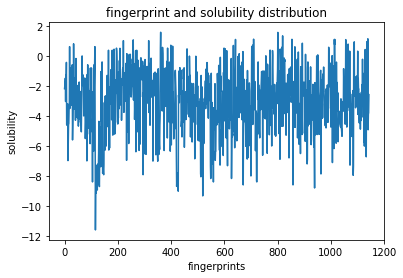

The mean of the solubility is: -3.0579973776223777
The S.D. of the solubility is: 2.0955854254462576


C:\Users\DR\Anaconda3\envs\my-rdkit-env\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


'In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function \nof a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population\nare made, based on a finite data sample.'

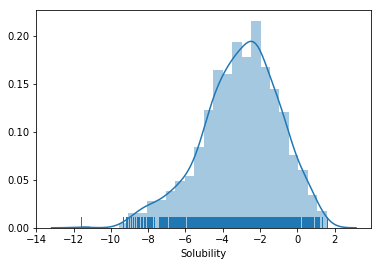

In [7]:
""" Visualize solubility """
# plot the solubility distribution
plt.plot(np.squeeze(train_y_b4))
plt.ylabel('solubility')
plt.xlabel('fingerprints')
plt.title("fingerprint and solubility distribution" )
plt.show()

# plot the histogram of solubility
import seaborn as sns
train_y_plot = pd.Series( np.squeeze(train_y_b4), name="Solubility")
mean = train_y_b4.mean()
std = train_y_b4.std()
print("The mean of the solubility is: " + str(mean))
print("The S.D. of the solubility is: " + str(std))
sns.distplot(train_y_plot, kde=True, rug=True, hist=True)
"""In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function 
of a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population
are made, based on a finite data sample."""

There are 606 soluble chemicals (positive samples) and 538 insoluble chemicals (negative samples).


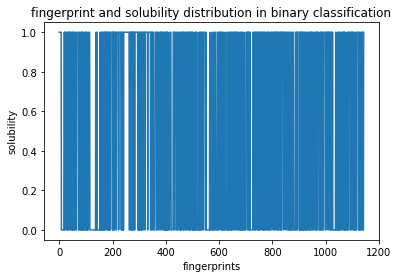

In [16]:
""" Hardmax the labels """
# convert train_y into a vector range from 0 to 1
train_y=np.zeros((1,len(data['Solubility'])))
for i in range(0,len(train_y_b4[0])):
    if (train_y_b4[0][i] >=mean):
        train_y[0][i]=1
    else:
        train_y[0][i]=0

print('There are '+ str(list(np.squeeze(train_y)).count(1)) + ' soluble chemicals (positive samples) and ' + str(list(np.squeeze(train_y)).count(0)) + ' insoluble chemicals (negative samples).')
        
# plot the input fingerprint length distribution plot
plt.plot(np.squeeze(train_y))
plt.ylabel('solubility')
plt.xlabel('fingerprints')
plt.title("fingerprint and solubility distribution in binary classification" )
plt.show()


In [8]:
"""This initially creates clusters of points normally distributed (std=1) about vertices of an n_informative-dimensional hypercube with sides of length 2*class_sep and assigns an equal number of clusters to each class. It introduces interdependence between these features and adds various types of further noise to the data."""
# Number of features
number_of_features = 4096
# Generate features matrix and target vector
features, target = make_classification(n_samples = 1144,
                                       n_features = number_of_features,
                                       n_informative = 3,
                                       n_redundant = 0,
                                       n_classes = 2,
                                       weights = [.5, .5],
                                       random_state = 0)

In [45]:
#Try Adam as optimizer and implement time-based learning rate decay lr *= (1. / (1. + self.decay * self.iterations))
def create_network():
    
    # Start neural network
    network = models.Sequential()

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=20, activation='relu', input_shape=(number_of_features,)))
    
    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=7, activation='relu'))

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=5, activation='relu'))

    # Add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1, activation='sigmoid'))
    
    # Setup hyperparameters for Adam optimizer
    Adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
    
    # Compile neural network
    network.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer= Adam, # Root Mean Square Propagation
                    metrics=['accuracy']) # Accuracy performance metric
  
    # Return compiled network
    return network

SyntaxError: invalid character in identifier (<ipython-input-45-3be43f26a682>, line 17)

In [10]:
# Wrap Keras model so it can be used by scikit-learn
neural_network_Adam = KerasClassifier(build_fn=create_network, 
                                 epochs=5000, 
                                 batch_size=100, 
                                 verbose=0)

neural_network_Adam_batchGD = KerasClassifier(build_fn=create_network, 
                                 epochs=5000, 
                                 batch_size=1144, 
                                 verbose=0)

In [9]:
#Try Adam as optimizer and implement time-based learning rate decay lr *= (1. / (1. + self.decay * self.iterations))
def create_network():
    
    # Start neural network
    network = models.Sequential()

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=20, activation='relu', input_shape=(number_of_features,)))
    
    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=7, activation='relu'))

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=5, activation='relu'))

    # Add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1))
    
    # Setup hyperparameters for Adam optimizer
    Adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
    
    # Compile neural network
    network.compile(loss='mean_squared_error', # Cross-entropy
                    optimizer= Adam, # Root Mean Square Propagation
                    metrics=['accuracy']) # Accuracy performance metric
  
    # Return compiled network
    return network

In [29]:
"""hold-out"""
X_train, X_test, y_train, y_test = train_test_split(train_x_flatten.T, train_y.T, test_size=0.10)

In [38]:
network=create_network()
network.fit(X_train,  y_train,batch_size=5, epochs=5)

Epoch 1/5
1029/1029 [==============================] - 1s 1ms/step - loss: 0.5779 - acc: 0.7318
Epoch 2/5
1029/1029 [==============================] - 1s 922us/step - loss: 0.3869 - acc: 0.8426
Epoch 3/5
1029/1029 [==============================] - 1s 874us/step - loss: 0.3149 - acc: 0.8766
Epoch 4/5
1029/1029 [==============================] - 1s 958us/step - loss: 0.2662 - acc: 0.9009
Epoch 5/5
1029/1029 [==============================] - 1s 922us/step - loss: 0.2245 - acc: 0.9067


In [11]:
import statsmodels.api as sm
import math

def get_r2_numpy(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y, ddof=1)))
    return r_squared

def get_r2_scipy(x, y):
    _, _, r_value, _, _ = stats.linregress(x, y)
    return r_value**2

def get_r2_statsmodels(x, y):
    return sm.OLS(y, sm.add_constant(x)).fit().rsquared

Epoch 1/500
762/762 [==============================] - 1s 2ms/step - loss: 3.0310 - acc: 0.0079
Epoch 2/500
762/762 [==============================] - 0s 514us/step - loss: 1.4309 - acc: 0.0039
Epoch 3/500
762/762 [==============================] - 0s 520us/step - loss: 1.1420 - acc: 0.0066
Epoch 4/500
762/762 [==============================] - 0s 529us/step - loss: 1.0224 - acc: 0.0092
Epoch 5/500
762/762 [==============================] - 0s 533us/step - loss: 0.9751 - acc: 0.0079
Epoch 6/500
762/762 [==============================] - 0s 598us/step - loss: 0.8426 - acc: 0.0066
Epoch 7/500
762/762 [==============================] - 0s 633us/step - loss: 0.7331 - acc: 0.0079
Epoch 8/500
762/762 [==============================] - 0s 545us/step - loss: 0.6892 - acc: 0.0066
Epoch 9/500
762/762 [==============================] - 0s 521us/step - loss: 0.7711 - acc: 0.0079
Epoch 10/500
762/762 [==============================] - 0s 531us/step - loss: 0.6869 - acc: 0.0131
Epoch 11/500
762/762 

762/762 [==============================] - 0s 483us/step - loss: 0.4221 - acc: 0.0118
Epoch 84/500
762/762 [==============================] - 1s 682us/step - loss: 0.4715 - acc: 0.0066
Epoch 85/500
762/762 [==============================] - 0s 501us/step - loss: 0.4153 - acc: 0.0105
Epoch 86/500
762/762 [==============================] - 0s 462us/step - loss: 0.3810 - acc: 0.0105
Epoch 87/500
762/762 [==============================] - 0s 451us/step - loss: 0.3877 - acc: 0.0131
Epoch 88/500
762/762 [==============================] - 0s 449us/step - loss: 0.3809 - acc: 0.0118
Epoch 89/500
762/762 [==============================] - 0s 465us/step - loss: 0.3936 - acc: 0.0105
Epoch 90/500
762/762 [==============================] - 0s 454us/step - loss: 0.3743 - acc: 0.0131
Epoch 91/500
762/762 [==============================] - 0s 465us/step - loss: 0.3860 - acc: 0.0118
Epoch 92/500
762/762 [==============================] - 0s 507us/step - loss: 0.3976 - acc: 0.0092
Epoch 93/500
762/762 [=

762/762 [==============================] - 0s 453us/step - loss: 0.3658 - acc: 0.0131
Epoch 166/500
762/762 [==============================] - 0s 461us/step - loss: 0.4081 - acc: 0.0131
Epoch 167/500
762/762 [==============================] - 0s 446us/step - loss: 0.3914 - acc: 0.0118
Epoch 168/500
762/762 [==============================] - 0s 443us/step - loss: 0.3787 - acc: 0.0131
Epoch 169/500
762/762 [==============================] - 0s 430us/step - loss: 0.3526 - acc: 0.0131
Epoch 170/500
762/762 [==============================] - 0s 450us/step - loss: 0.3830 - acc: 0.0118
Epoch 171/500
762/762 [==============================] - 0s 434us/step - loss: 0.3631 - acc: 0.0144
Epoch 172/500
762/762 [==============================] - 0s 453us/step - loss: 0.3890 - acc: 0.0105
Epoch 173/500
762/762 [==============================] - 0s 450us/step - loss: 0.3489 - acc: 0.0118
Epoch 174/500
762/762 [==============================] - 0s 583us/step - loss: 0.3753 - acc: 0.0118
Epoch 175/500


762/762 [==============================] - 0s 491us/step - loss: 0.3441 - acc: 0.0131
Epoch 248/500
762/762 [==============================] - 0s 475us/step - loss: 0.3555 - acc: 0.0118
Epoch 249/500
762/762 [==============================] - 0s 450us/step - loss: 0.3798 - acc: 0.0131
Epoch 250/500
762/762 [==============================] - 0s 450us/step - loss: 0.3599 - acc: 0.0118
Epoch 251/500
762/762 [==============================] - 0s 454us/step - loss: 0.3649 - acc: 0.0118
Epoch 252/500
762/762 [==============================] - 0s 450us/step - loss: 0.3440 - acc: 0.0118
Epoch 253/500
762/762 [==============================] - 0s 450us/step - loss: 0.3660 - acc: 0.0144
Epoch 254/500
762/762 [==============================] - 0s 450us/step - loss: 0.3528 - acc: 0.0131
Epoch 255/500
762/762 [==============================] - 0s 471us/step - loss: 0.3793 - acc: 0.0092
Epoch 256/500
762/762 [==============================] - 0s 430us/step - loss: 0.3920 - acc: 0.0131
Epoch 257/500


762/762 [==============================] - 0s 504us/step - loss: 0.3512 - acc: 0.0131
Epoch 330/500
762/762 [==============================] - 0s 543us/step - loss: 0.3611 - acc: 0.0118
Epoch 331/500
762/762 [==============================] - 0s 479us/step - loss: 0.3824 - acc: 0.0131
Epoch 332/500
762/762 [==============================] - 0s 478us/step - loss: 0.3410 - acc: 0.0118
Epoch 333/500
762/762 [==============================] - 0s 482us/step - loss: 0.3433 - acc: 0.0131
Epoch 334/500
762/762 [==============================] - 0s 470us/step - loss: 0.3555 - acc: 0.0105
Epoch 335/500
762/762 [==============================] - 0s 466us/step - loss: 0.3410 - acc: 0.0131
Epoch 336/500
762/762 [==============================] - 0s 476us/step - loss: 0.3508 - acc: 0.0144
Epoch 337/500
762/762 [==============================] - 0s 457us/step - loss: 0.3495 - acc: 0.0105
Epoch 338/500
762/762 [==============================] - 0s 465us/step - loss: 0.3602 - acc: 0.0118
Epoch 339/500


762/762 [==============================] - 0s 453us/step - loss: 0.3752 - acc: 0.0131
Epoch 412/500
762/762 [==============================] - 0s 468us/step - loss: 0.3538 - acc: 0.0144
Epoch 413/500
762/762 [==============================] - 0s 450us/step - loss: 0.3367 - acc: 0.0131
Epoch 414/500
762/762 [==============================] - 0s 450us/step - loss: 0.3466 - acc: 0.0131
Epoch 415/500
762/762 [==============================] - 0s 464us/step - loss: 0.3304 - acc: 0.0144
Epoch 416/500
762/762 [==============================] - 0s 471us/step - loss: 0.3268 - acc: 0.0118
Epoch 417/500
762/762 [==============================] - 0s 498us/step - loss: 0.3444 - acc: 0.0131
Epoch 418/500
762/762 [==============================] - 0s 473us/step - loss: 0.3504 - acc: 0.0118
Epoch 419/500
762/762 [==============================] - 0s 471us/step - loss: 0.3635 - acc: 0.0105
Epoch 420/500
762/762 [==============================] - 0s 452us/step - loss: 0.3383 - acc: 0.0118
Epoch 421/500


762/762 [==============================] - 0s 448us/step - loss: 0.3400 - acc: 0.0118
Epoch 494/500
762/762 [==============================] - 0s 450us/step - loss: 0.3472 - acc: 0.0131
Epoch 495/500
762/762 [==============================] - 0s 450us/step - loss: 0.3296 - acc: 0.0131
Epoch 496/500
762/762 [==============================] - 0s 439us/step - loss: 0.3325 - acc: 0.0118
Epoch 497/500
762/762 [==============================] - 0s 471us/step - loss: 0.3422 - acc: 0.0118
Epoch 498/500
762/762 [==============================] - 0s 450us/step - loss: 0.3588 - acc: 0.0131
Epoch 499/500
762/762 [==============================] - 0s 454us/step - loss: 0.3318 - acc: 0.0105
Epoch 500/500
762/762 [==============================] - 0s 471us/step - loss: 0.3321 - acc: 0.0118


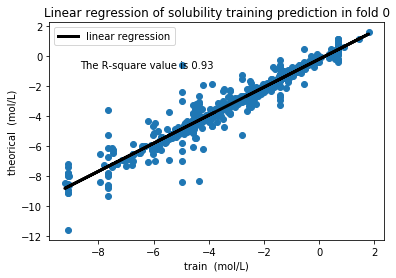

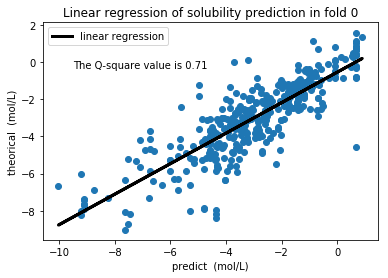

Epoch 1/500
763/763 [==============================] - 0s 491us/step - loss: 0.7818 - acc: 0.0066
Epoch 2/500
763/763 [==============================] - 0s 473us/step - loss: 0.6057 - acc: 0.0052
Epoch 3/500
763/763 [==============================] - 0s 470us/step - loss: 0.5514 - acc: 0.0066
Epoch 4/500
763/763 [==============================] - 0s 470us/step - loss: 0.5325 - acc: 0.0092
Epoch 5/500
763/763 [==============================] - 0s 454us/step - loss: 0.4837 - acc: 0.0079
Epoch 6/500
763/763 [==============================] - 0s 470us/step - loss: 0.4848 - acc: 0.0092
Epoch 7/500
763/763 [==============================] - 0s 491us/step - loss: 0.4640 - acc: 0.0079
Epoch 8/500
763/763 [==============================] - 0s 470us/step - loss: 0.4534 - acc: 0.0092
Epoch 9/500
763/763 [==============================] - 0s 470us/step - loss: 0.4265 - acc: 0.0092
Epoch 10/500
763/763 [==============================] - 0s 471us/step - loss: 0.4201 - acc: 0.0079
Epoch 11/500
763/76

763/763 [==============================] - 0s 469us/step - loss: 0.2955 - acc: 0.0092
Epoch 84/500
763/763 [==============================] - 0s 511us/step - loss: 0.3027 - acc: 0.0092
Epoch 85/500
763/763 [==============================] - 0s 467us/step - loss: 0.2995 - acc: 0.0092
Epoch 86/500
763/763 [==============================] - 0s 472us/step - loss: 0.3538 - acc: 0.0079
Epoch 87/500
763/763 [==============================] - 0s 470us/step - loss: 0.3091 - acc: 0.0079
Epoch 88/500
763/763 [==============================] - 0s 477us/step - loss: 0.2923 - acc: 0.0092
Epoch 89/500
763/763 [==============================] - 0s 491us/step - loss: 0.2940 - acc: 0.0079
Epoch 90/500
763/763 [==============================] - 0s 450us/step - loss: 0.3060 - acc: 0.0079
Epoch 91/500
763/763 [==============================] - 0s 472us/step - loss: 0.2959 - acc: 0.0079
Epoch 92/500
763/763 [==============================] - 0s 470us/step - loss: 0.2928 - acc: 0.0079
Epoch 93/500
763/763 [=

763/763 [==============================] - 0s 491us/step - loss: 0.2870 - acc: 0.0092
Epoch 166/500
763/763 [==============================] - 0s 553us/step - loss: 0.2949 - acc: 0.0079
Epoch 167/500
763/763 [==============================] - 0s 472us/step - loss: 0.2933 - acc: 0.0092
Epoch 168/500
763/763 [==============================] - 0s 470us/step - loss: 0.3003 - acc: 0.0092
Epoch 169/500
763/763 [==============================] - 0s 472us/step - loss: 0.3047 - acc: 0.0092
Epoch 170/500
763/763 [==============================] - 0s 470us/step - loss: 0.2946 - acc: 0.0079
Epoch 171/500
763/763 [==============================] - 0s 552us/step - loss: 0.2920 - acc: 0.0092
Epoch 172/500
763/763 [==============================] - 0s 473us/step - loss: 0.3069 - acc: 0.0105
Epoch 173/500
763/763 [==============================] - 0s 470us/step - loss: 0.2876 - acc: 0.0092
Epoch 174/500
763/763 [==============================] - 0s 470us/step - loss: 0.2921 - acc: 0.0092
Epoch 175/500


763/763 [==============================] - 0s 470us/step - loss: 0.2846 - acc: 0.0079
Epoch 248/500
763/763 [==============================] - 0s 450us/step - loss: 0.2897 - acc: 0.0092
Epoch 249/500
763/763 [==============================] - 0s 470us/step - loss: 0.2981 - acc: 0.0092
Epoch 250/500
763/763 [==============================] - 0s 473us/step - loss: 0.2941 - acc: 0.0079
Epoch 251/500
763/763 [==============================] - 0s 452us/step - loss: 0.3104 - acc: 0.0079
Epoch 252/500
763/763 [==============================] - 0s 470us/step - loss: 0.2880 - acc: 0.0092
Epoch 253/500
763/763 [==============================] - 0s 470us/step - loss: 0.2984 - acc: 0.0079
Epoch 254/500
763/763 [==============================] - 0s 450us/step - loss: 0.2907 - acc: 0.0092
Epoch 255/500
763/763 [==============================] - 0s 470us/step - loss: 0.2876 - acc: 0.0092
Epoch 256/500
763/763 [==============================] - 0s 509us/step - loss: 0.2920 - acc: 0.0092
Epoch 257/500


763/763 [==============================] - 0s 637us/step - loss: 0.2799 - acc: 0.0092
Epoch 330/500
763/763 [==============================] - 1s 724us/step - loss: 0.2765 - acc: 0.0092ETA: 0s - loss: 0.3321 - ac
Epoch 331/500
763/763 [==============================] - 0s 603us/step - loss: 0.3022 - acc: 0.0092
Epoch 332/500
763/763 [==============================] - 0s 557us/step - loss: 0.2917 - acc: 0.0079
Epoch 333/500
763/763 [==============================] - 0s 602us/step - loss: 0.2828 - acc: 0.0092
Epoch 334/500
763/763 [==============================] - 0s 548us/step - loss: 0.2859 - acc: 0.0092
Epoch 335/500
763/763 [==============================] - 0s 541us/step - loss: 0.2728 - acc: 0.0092
Epoch 336/500
763/763 [==============================] - 0s 592us/step - loss: 0.2750 - acc: 0.0092
Epoch 337/500
763/763 [==============================] - 0s 608us/step - loss: 0.2930 - acc: 0.0079
Epoch 338/500
763/763 [==============================] - 0s 596us/step - loss: 0.3045 -

763/763 [==============================] - 0s 458us/step - loss: 0.2829 - acc: 0.0079
Epoch 411/500
763/763 [==============================] - 0s 465us/step - loss: 0.2781 - acc: 0.0079
Epoch 412/500
763/763 [==============================] - 0s 470us/step - loss: 0.2906 - acc: 0.0079
Epoch 413/500
763/763 [==============================] - 0s 502us/step - loss: 0.2805 - acc: 0.0092
Epoch 414/500
763/763 [==============================] - 0s 477us/step - loss: 0.2826 - acc: 0.0079
Epoch 415/500
763/763 [==============================] - 0s 473us/step - loss: 0.2842 - acc: 0.0079
Epoch 416/500
763/763 [==============================] - 0s 479us/step - loss: 0.2853 - acc: 0.0092
Epoch 417/500
763/763 [==============================] - 0s 467us/step - loss: 0.2872 - acc: 0.0079
Epoch 418/500
763/763 [==============================] - 0s 501us/step - loss: 0.2761 - acc: 0.0092
Epoch 419/500
763/763 [==============================] - 0s 498us/step - loss: 0.2805 - acc: 0.0092
Epoch 420/500


763/763 [==============================] - 0s 494us/step - loss: 0.2743 - acc: 0.0079
Epoch 492/500
763/763 [==============================] - 0s 491us/step - loss: 0.2748 - acc: 0.0092
Epoch 493/500
763/763 [==============================] - 0s 470us/step - loss: 0.2803 - acc: 0.0079
Epoch 494/500
763/763 [==============================] - 0s 472us/step - loss: 0.2810 - acc: 0.0092
Epoch 495/500
763/763 [==============================] - 0s 473us/step - loss: 0.2849 - acc: 0.0092
Epoch 496/500
763/763 [==============================] - 0s 485us/step - loss: 0.2807 - acc: 0.0079
Epoch 497/500
763/763 [==============================] - 0s 496us/step - loss: 0.2770 - acc: 0.0092
Epoch 498/500
763/763 [==============================] - ETA: 0s - loss: 0.2813 - acc: 0.010 - 0s 470us/step - loss: 0.2812 - acc: 0.0092
Epoch 499/500
763/763 [==============================] - 0s 467us/step - loss: 0.2757 - acc: 0.0092
Epoch 500/500
763/763 [==============================] - 0s 473us/step - los

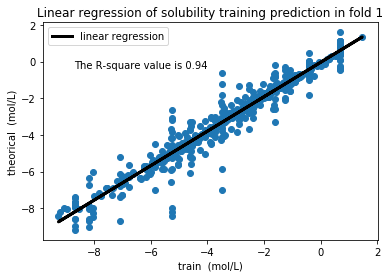

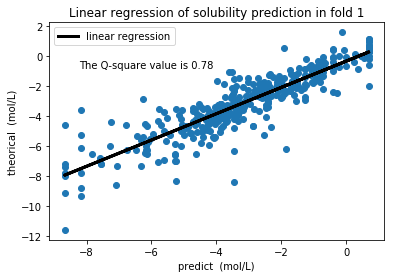

Epoch 1/500
763/763 [==============================] - 0s 496us/step - loss: 0.7240 - acc: 0.0157
Epoch 2/500
763/763 [==============================] - 0s 446us/step - loss: 0.5988 - acc: 0.0157
Epoch 3/500
763/763 [==============================] - 0s 470us/step - loss: 0.5426 - acc: 0.0157
Epoch 4/500
763/763 [==============================] - 0s 439us/step - loss: 0.5062 - acc: 0.0170
Epoch 5/500
763/763 [==============================] - 0s 450us/step - loss: 0.4572 - acc: 0.0157
Epoch 6/500
763/763 [==============================] - 0s 450us/step - loss: 0.4688 - acc: 0.0183
Epoch 7/500
763/763 [==============================] - 0s 469us/step - loss: 0.4178 - acc: 0.0170
Epoch 8/500
763/763 [==============================] - 0s 452us/step - loss: 0.4311 - acc: 0.0157
Epoch 9/500
763/763 [==============================] - 0s 450us/step - loss: 0.4409 - acc: 0.0170
Epoch 10/500
763/763 [==============================] - 0s 464us/step - loss: 0.4196 - acc: 0.0170
Epoch 11/500
763/76

763/763 [==============================] - 0s 541us/step - loss: 0.3438 - acc: 0.0144
Epoch 84/500
763/763 [==============================] - 0s 486us/step - loss: 0.3490 - acc: 0.0170
Epoch 85/500
763/763 [==============================] - 0s 452us/step - loss: 0.3519 - acc: 0.0170
Epoch 86/500
763/763 [==============================] - 0s 477us/step - loss: 0.3435 - acc: 0.0170
Epoch 87/500
763/763 [==============================] - 0s 431us/step - loss: 0.3548 - acc: 0.0183
Epoch 88/500
763/763 [==============================] - 0s 509us/step - loss: 0.3602 - acc: 0.0183
Epoch 89/500
763/763 [==============================] - 0s 532us/step - loss: 0.3615 - acc: 0.0170
Epoch 90/500
763/763 [==============================] - 0s 451us/step - loss: 0.3689 - acc: 0.0183
Epoch 91/500
763/763 [==============================] - 0s 522us/step - loss: 0.3798 - acc: 0.0170
Epoch 92/500
763/763 [==============================] - 0s 462us/step - loss: 0.3548 - acc: 0.0157
Epoch 93/500
763/763 [=

763/763 [==============================] - 0s 450us/step - loss: 0.3331 - acc: 0.0170
Epoch 166/500
763/763 [==============================] - 0s 452us/step - loss: 0.3655 - acc: 0.0157
Epoch 167/500
763/763 [==============================] - 0s 455us/step - loss: 0.3248 - acc: 0.0170
Epoch 168/500
763/763 [==============================] - 0s 450us/step - loss: 0.3671 - acc: 0.0157
Epoch 169/500
763/763 [==============================] - 0s 469us/step - loss: 0.3396 - acc: 0.0170
Epoch 170/500
763/763 [==============================] - 0s 470us/step - loss: 0.3388 - acc: 0.0170
Epoch 171/500
763/763 [==============================] - 0s 470us/step - loss: 0.3792 - acc: 0.0157
Epoch 172/500
763/763 [==============================] - 0s 448us/step - loss: 0.3599 - acc: 0.0157
Epoch 173/500
763/763 [==============================] - 0s 511us/step - loss: 0.3529 - acc: 0.0157
Epoch 174/500
763/763 [==============================] - 0s 473us/step - loss: 0.3535 - acc: 0.0157
Epoch 175/500


763/763 [==============================] - 0s 466us/step - loss: 0.3391 - acc: 0.0157
Epoch 248/500
763/763 [==============================] - 0s 470us/step - loss: 0.3261 - acc: 0.0170
Epoch 249/500
763/763 [==============================] - 0s 436us/step - loss: 0.3267 - acc: 0.0157
Epoch 250/500
763/763 [==============================] - 0s 470us/step - loss: 0.3491 - acc: 0.0183
Epoch 251/500
763/763 [==============================] - 0s 452us/step - loss: 0.3360 - acc: 0.0157
Epoch 252/500
763/763 [==============================] - 0s 448us/step - loss: 0.3484 - acc: 0.0157
Epoch 253/500
763/763 [==============================] - 0s 470us/step - loss: 0.3938 - acc: 0.0144
Epoch 254/500
763/763 [==============================] - 0s 450us/step - loss: 0.3415 - acc: 0.0170
Epoch 255/500
763/763 [==============================] - 0s 455us/step - loss: 0.3740 - acc: 0.0170
Epoch 256/500
763/763 [==============================] - 0s 470us/step - loss: 0.3368 - acc: 0.0157
Epoch 257/500


763/763 [==============================] - 0s 450us/step - loss: 0.3343 - acc: 0.0170
Epoch 329/500
763/763 [==============================] - 0s 470us/step - loss: 0.3300 - acc: 0.0170
Epoch 330/500
763/763 [==============================] - 0s 451us/step - loss: 0.3428 - acc: 0.0170
Epoch 331/500
763/763 [==============================] - 0s 450us/step - loss: 0.3304 - acc: 0.0170
Epoch 332/500
763/763 [==============================] - 0s 450us/step - loss: 0.3419 - acc: 0.0157
Epoch 333/500
763/763 [==============================] - 0s 458us/step - loss: 0.3593 - acc: 0.0157
Epoch 334/500
763/763 [==============================] - 0s 473us/step - loss: 0.3421 - acc: 0.0157
Epoch 335/500
763/763 [==============================] - 0s 459us/step - loss: 0.3384 - acc: 0.0183
Epoch 336/500
763/763 [==============================] - 0s 432us/step - loss: 0.3424 - acc: 0.0170
Epoch 337/500
763/763 [==============================] - 0s 450us/step - loss: 0.3435 - acc: 0.0183
Epoch 338/500


763/763 [==============================] - 0s 450us/step - loss: 0.3341 - acc: 0.0170
Epoch 411/500
763/763 [==============================] - 0s 473us/step - loss: 0.3374 - acc: 0.0170
Epoch 412/500
763/763 [==============================] - 0s 543us/step - loss: 0.3741 - acc: 0.0170
Epoch 413/500
763/763 [==============================] - 0s 613us/step - loss: 0.3325 - acc: 0.0170
Epoch 414/500
763/763 [==============================] - 0s 587us/step - loss: 0.3506 - acc: 0.0170
Epoch 415/500
763/763 [==============================] - 0s 470us/step - loss: 0.3328 - acc: 0.0183
Epoch 416/500
763/763 [==============================] - 0s 443us/step - loss: 0.3428 - acc: 0.0170
Epoch 417/500
763/763 [==============================] - 0s 525us/step - loss: 0.3263 - acc: 0.0170
Epoch 418/500
763/763 [==============================] - 0s 486us/step - loss: 0.3431 - acc: 0.0183
Epoch 419/500
763/763 [==============================] - 0s 446us/step - loss: 0.3403 - acc: 0.0170
Epoch 420/500


763/763 [==============================] - 0s 476us/step - loss: 0.3416 - acc: 0.0157
Epoch 492/500
763/763 [==============================] - 0s 463us/step - loss: 0.3249 - acc: 0.0183
Epoch 493/500
763/763 [==============================] - 0s 467us/step - loss: 0.3377 - acc: 0.0157
Epoch 494/500
763/763 [==============================] - 0s 471us/step - loss: 0.3223 - acc: 0.0170
Epoch 495/500
763/763 [==============================] - 0s 589us/step - loss: 0.3568 - acc: 0.0157
Epoch 496/500
763/763 [==============================] - 0s 604us/step - loss: 0.3300 - acc: 0.0183
Epoch 497/500
763/763 [==============================] - 0s 623us/step - loss: 0.3262 - acc: 0.0170
Epoch 498/500
763/763 [==============================] - 0s 640us/step - loss: 0.3222 - acc: 0.0170
Epoch 499/500
763/763 [==============================] - 0s 506us/step - loss: 0.3165 - acc: 0.0157
Epoch 500/500
763/763 [==============================] - 0s 583us/step - loss: 0.3500 - acc: 0.0157


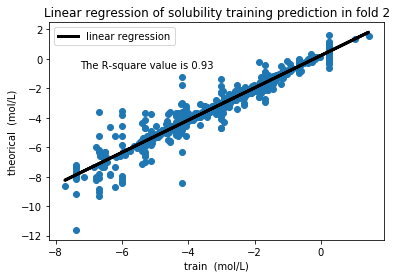

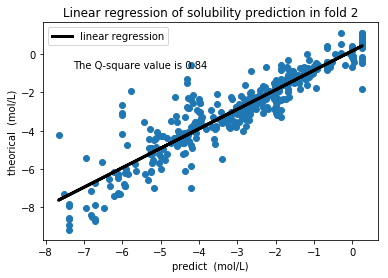

In [45]:
"""StratifiedKFold"""
from scipy import stats
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import KFold 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
train_xx=train_x_flatten.T
train_yy=train_y_b4.T
# Split the dataset in 3 folds
sfolder = KFold(n_splits=3,random_state=0,shuffle=True)
sfolder.get_n_splits(train_xx,train_yy)

network=create_network()
predict=[]
train_=[]
i=0

for i, (train, test) in enumerate(sfolder.split(train_xx,train_yy)):
    X_train, X_test = train_xx[train], train_xx[test]
    y_train, y_test = train_yy[train], train_yy[test]

    # Train the model with each combination of folds
    network.fit(X_train,  y_train,batch_size=5, epochs=500)
    train_.append(network.predict(X_train))
    predict.append(network.predict(X_test))
    
    
    r_square=get_r2_statsmodels(train_[i],y_train)
    q_square=get_r2_statsmodels(predict[i],y_test)
    
    model=LinearRegression()
    model.fit(train_[i],y_train)
    ax=plt.gca()
    plt.scatter(train_[i],y_train)
    y_train_pred=model.predict(train_[i])
    plt.title('Linear regression of solubility training prediction in fold '+str(i))
    plt.text(0.5,0.78,"The R-square value is %.2f " % r_square, verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes)
    plt.plot(train_[i],y_train_pred,color='black',linewidth=3,label="linear regression")
    plt.legend(loc=2)
    plt.xlabel("train  (mol/L)")
    plt.ylabel("theorical  (mol/L)")
    plt.show()
    
    model=LinearRegression()
    model.fit(predict[i],y_test)
    ax=plt.gca()
    plt.scatter(predict[i],y_test)
    y_train_pred=model.predict(predict[i])
    plt.title('Linear regression of solubility prediction in fold '+str(i))
    plt.text(0.5,0.78,"The Q-square value is %.2f " % q_square,verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes)
    plt.plot(predict[i],y_train_pred,color='black',linewidth=3,label="linear regression")
    plt.legend(loc=2)
    plt.xlabel("predict  (mol/L)")
    plt.ylabel("theorical  (mol/L)")
    plt.show()
    
    i=i+1

In [13]:
# Prediction of accuracy in folds of 3
cross_val_score(neural_network_Adam,train_x_flatten.T, train_y.T, cv=3)

NameError: name 'train_y' is not defined

In [14]:
# Prediction of accuracy in folds of 3 with batch gredient descent
cross_val_score(neural_network_Adam_batchGD,train_x_flatten.T, train_y.T, cv=3)

NameError: name 'train_y' is not defined